In [1]:
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
from matplotlib.colors import Normalize
import pandas as pd
import numpy as np
import os
from pathlib import Path
from variability_utils import *
plt.rcParams['figure.dpi'] = 120

In [2]:
data_path = os.environ.get("FLYVIS_DATA_PATH", "data")
data_path = os.path.expanduser(data_path)
p = Path(data_path)
p.mkdir(parents=True, exist_ok=True)

is_empty = not any(p.iterdir())

if is_empty:
    # !python -m pip -q install -U gdown # uncomment if gdown is not installed
    !gdown --folder "https://drive.google.com/drive/folders/1B91un2NpSaKSHol8KmfpQCB2KeGnS4pj" -O "{data_path}"
else:
    print(f"Data directory not empty, skipping download: {data_path}")



Retrieving folder contents
Processing file 1tpTVxYWdKDR20IA34QTRVp3fuCXZfNce column_assignment.csv
Processing file 1c3eauWIIbWTzMM-8k40qJMt7AJlfQO2X connections_princeton.csv
Processing file 1neszkexrgBWbDRVJsIe1s1XXJvu-aqxU connections_princeton.csv.gzZone.Identifier
Processing file 1hD2lZ6f9Uq_oB0vw4XGjyA_LqymqbkrA fafb_783_meta.feather
Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1tpTVxYWdKDR20IA34QTRVp3fuCXZfNce
To: /home/guardomayas/NUIN/sjbcs/fly_wire_perturbations/data/column_assignment.csv
100%|██████████████████████████████████████| 1.99M/1.99M [00:00<00:00, 3.38MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1c3eauWIIbWTzMM-8k40qJMt7AJlfQO2X
From (redirected): https://drive.google.com/uc?id=1c3eauWIIbWTzMM-8k40qJMt7AJlfQO2X&confirm=t&uuid=bbc9a94d-c3ea-481f-89e8-f688705286ff
To: /home/guardomayas/NUIN/sjbcs/fly_wire_perturbations/data/connectio

In [3]:
codex_meta = pd.read_csv(os.path.join(data_path, 'column_assignment.csv'))
codex_meta["root_id"] = pd.to_numeric(codex_meta["root_id"], errors="coerce") 
root_ids = codex_meta["root_id"].dropna().astype("int64").to_numpy()
fafb_meta = pd.read_feather(os.path.join(data_path, 'fafb_783_meta.feather'))
fafb_meta["fafb_783_id"] = pd.to_numeric(fafb_meta["fafb_783_id"], errors="coerce") 
fafb_meta["fafb_783_id"] = fafb_meta["fafb_783_id"].dropna().astype("int64")

edge_df = pd.read_csv(os.path.join(data_path, 'connections_princeton.csv'))

In [4]:
## Pick your favorite couple:
source_type, target_type = "L3", "Tm9"

In [5]:
cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=0, vmax=50)

nodes_R = build_nodes_coords_for_side("right",fafb_meta, codex_meta, root_ids)
edges_R = build_edges_for_nodes(nodes_R, edge_df)

nodes_L = build_nodes_coords_for_side("left",fafb_meta, codex_meta, root_ids)
edges_L = build_edges_for_nodes(nodes_L, edge_df)
print(edges_R['pre_cell_type'].unique())
print(edges_R['post_cell_type'].unique())
# print(edges_R.to_markdown())

['Tm2' 'L5' 'Tm9' 'Mi9' 'L2' 'Tm3' 'L3' 'Tm1' 'C2' 'R7' 'Mi4' 'R8' 'Tm4'
 'L1' 'Mi1' 'Tm20' 'C3' 'T1' 'L4' 'T3' 'T4a' 'T2' 'T4b' 'T2a' 'T4c' 'T5c'
 'T5d' 'T5b' None 'T5a' 'Tm21' 'T4d']
['T5b' 'Tm3' 'T5a' 'T4c' 'Tm4' 'Mi1' 'Mi4' 'L2' 'T5d' 'L3' 'T2' 'T3' 'Mi9'
 'R8' 'L4' 'L5' 'Tm9' 'L1' 'Tm2' 'T5c' 'C2' 'T2a' 'Tm1' 'T1' 'Tm20' 'T4b'
 'R7' 'C3' 'T4d' 'Tm21' 'T4a' None]


Column 244 has 2 edges; using mean.
Column 328 has 3 edges; using mean.


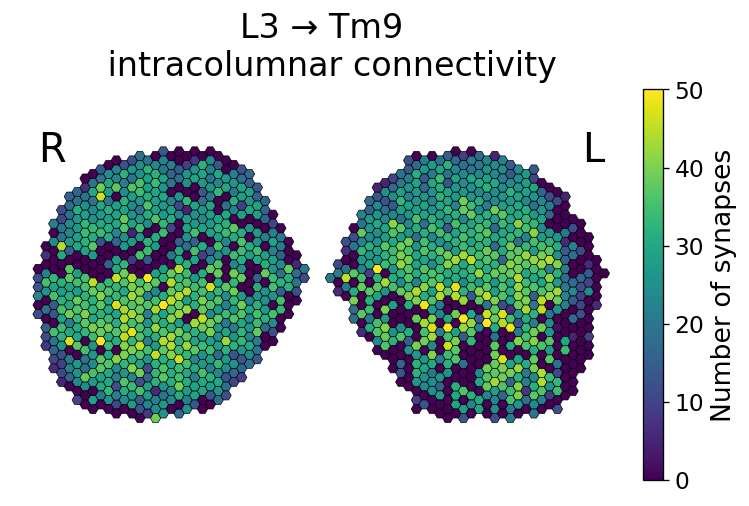

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.set_aspect("equal")
ax.axis("off")
fig.suptitle(f"{source_type} → {target_type} \n intracolumnar connectivity", fontsize=20, x=0.5,y=0.95)

colpos_R = nodes_R[["column_id","p","q"]].drop_duplicates("column_id")
xR0, yR0 = pq_to_xy(colpos_R["p"].to_numpy(), colpos_R["q"].to_numpy(), hexsize=1.0)
eye_width = xR0.max() - xR0.min()
gap = 4.0 

xR, yR = plot_eye(ax, nodes_R, edges_R, source_type, target_type, norm, cmap,
                  mirror_x=True, x_offset=-(eye_width/2 + gap), hexsize=1.0, plot_col_ids=False)
xL, yL = plot_eye(ax, nodes_L, edges_L, source_type, target_type, norm, cmap,
                  mirror_x=False,  x_offset=+(eye_width/2 + gap), hexsize=1.0, plot_col_ids=False)

xmin = min(xR.min(), xL.min()) - 5
xmax = max(xR.max(), xL.max()) + 5
ymin = min(yR.min(), yL.min()) - 5
ymax = max(yR.max(), yL.max()) + 5
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)


ax.text(xR.min(), ymax-1, "R", fontsize=24, ha="left", va="top")
ax.text(xL.max(), ymax-1, "L",  fontsize=24, ha="right", va="top")

mappable = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
cb = fig.colorbar(mappable, ax=ax, fraction=0.03, pad=0.02)
cb.set_label("Number of synapses", fontsize=16)
cb.ax.tick_params(labelsize=14)
plt.show()
